![image.png](
    

)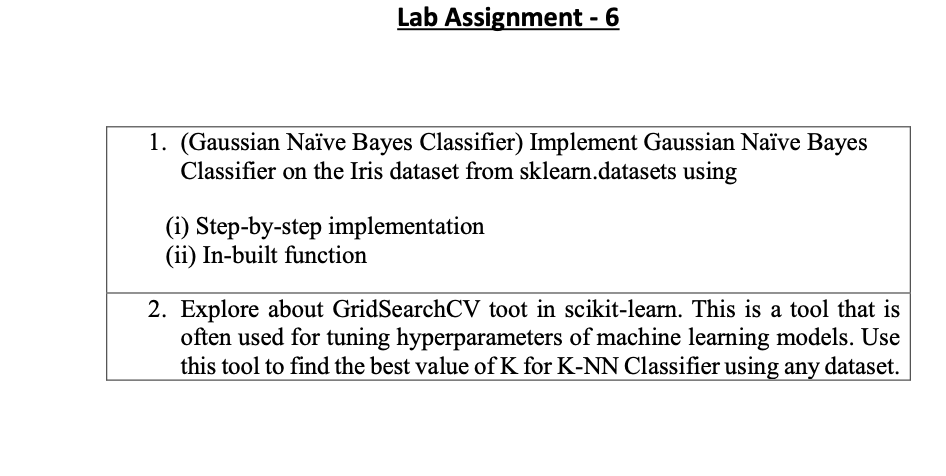

## Q1.(i)

In [1]:
# ---------- Gaussian Naive Bayes: Step-by-step implementation ----------
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


class MyGaussianNB:
    def __init__(self):
        self.classes_ = None      # unique class labels
        self.means_ = None        # shape: (n_classes, n_features)
        self.vars_ = None         # shape: (n_classes, n_features)
        self.priors_ = None       # shape: (n_classes,)

    def fit(self, X, y):
        """Estimate mean, variance and prior for each class."""
        X = np.array(X)
        y = np.array(y)

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        self.means_ = np.zeros((n_classes, n_features))
        self.vars_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]                           # samples of class c
            self.means_[idx, :] = X_c.mean(axis=0)    # μ_cj
            self.vars_[idx, :] = X_c.var(axis=0) + 1e-9  # σ²_cj  (+ small value for stability)
            self.priors_[idx] = X_c.shape[0] / X.shape[0]  # P(y=c)

        return self

    def _gaussian_likelihood(self, class_idx, x):
        """Compute P(x | y=class_idx) using Gaussian pdf (feature-wise)."""
        mean = self.means_[class_idx]
        var = self.vars_[class_idx]

        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator   # returns vector over features

    def _predict_single(self, x):
        """Compute posterior for each class and return the argmax."""
        posteriors = []

        for idx, c in enumerate(self.classes_):
            prior_log = np.log(self.priors_[idx])  # log P(y=c)
            # log P(x | y=c) = sum(log p(x_j | y=c))
            class_conditional_log = np.sum(np.log(self._gaussian_likelihood(idx, x)))
            posterior_log = prior_log + class_conditional_log
            posteriors.append(posterior_log)

        # class with highest posterior
        return self.classes_[np.argmax(posteriors)]

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_single(x) for x in X])


if __name__ == "__main__":
    # load iris dataset
    iris = load_iris()
    X, y = iris.data, iris.target

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # train custom Gaussian NB
    my_gnb = MyGaussianNB()
    my_gnb.fit(X_train, y_train)

    # predictions & evaluation
    y_pred_custom = my_gnb.predict(X_test)
    print("Custom GaussianNB Accuracy:", accuracy_score(y_test, y_pred_custom))
    print("\nClassification Report (Custom GNB):")
    print(classification_report(y_test, y_pred_custom, target_names=iris.target_names))


Custom GaussianNB Accuracy: 0.9111111111111111

Classification Report (Custom GNB):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



## Q2.(ii)

In [2]:
from sklearn.naive_bayes import GaussianNB

# ---------- Using built-in GaussianNB ----------
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_sklearn = gnb.predict(X_test)
print("Sklearn GaussianNB Accuracy:", accuracy_score(y_test, y_pred_sklearn))
print("\nClassification Report (Sklearn GNB):")
print(classification_report(y_test, y_pred_sklearn, target_names=iris.target_names))


Sklearn GaussianNB Accuracy: 0.9111111111111111

Classification Report (Sklearn GNB):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



## Q2

In [3]:
# ---------- GridSearchCV for tuning K in KNN ----------
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# load data
iris = load_iris()
X, y = iris.data, iris.target

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Pipeline: scale features -> KNN
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# hyperparameter grid for K
param_grid = {
    "knn__n_neighbors": list(range(1, 31)),   # test k = 1 to 30
    "knn__weights": ["uniform", "distance"]   # optional: different weightings
}

# GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                # 5-fold cross validation
    scoring="accuracy",
    n_jobs=-1            # use all cores
)

grid.fit(X_train, y_train)

print("Best params found:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate best model on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test accuracy with best K:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Best KNN):")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Best params found: {'knn__n_neighbors': 14, 'knn__weights': 'uniform'}
Best CV accuracy: 0.9714285714285715
Test accuracy with best K: 0.9555555555555556

Classification Report (Best KNN):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

